<h1 align="center">Volume 1: Facial Recognition.</h1>

    <Sam Layton> (double-click to edit)
    <Section 003>
    <11/17/22>

In [63]:
import os
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

### Helper Functions

In [64]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

### Problem 1 

- Implement `show()`.
- Use `show()` to display a face from the `faces94` dataset.

In [65]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    #Reshape the vector into a matrix and plot it
    reshaped = np.reshape(image, (m,n))
    plt.imshow(reshaped, cmap="gray")

    #Remove the axis and show the image
    plt.axis('off')

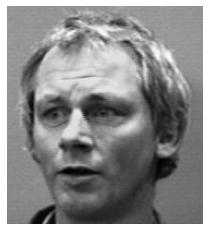

In [66]:
# Get the faces and show the first one.
show(get_faces()[:,0])

In [67]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    # Problems 2-3
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        # Get the faces and compute the mean.
        self.faces = get_faces(path)
        self.meanface = np.mean(self.faces, axis=1)

        # Subtract the mean from each face.
        self.shiftedfaces = self.faces - self.meanface.reshape(-1,1)

        # Compute the SVD of the shifted faces and store the U matrix.
        U, S, V = np.linalg.svd(self.shiftedfaces, full_matrices=False)
        self.U = U


    # Problem 3
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        # Make Us attribute a matrix of the first s eigenfaces.
        self.Us = self.U[:,:s]

        # Project the image onto the subspace
        return np.dot(self.Us.T, A)


    # Problem 5
    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        # Calculate mean shifted g projected onto the subspace and the 
        gshifted = g - self.meanface
        gproj = self.project(gshifted, s)
        projmatrix = self.project(self.shiftedfaces, s)

        # Calculate the distance between gproj and each face in shifted faces and take the argmin
        distances = np.linalg.norm(projmatrix - gproj.reshape(-1,1), axis=0)
        return np.argmin(distances)


    # Problem 6
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        # Get the index of the closest face.
        j = self.find_nearest(image, s)

        # Plot the original image
        plt.subplot(1,2,1)
        plt.title("Input Image")
        show(image, m, n)

        # Plot the closest match
        plt.subplot(1,2,2)
        plt.title("Closest Match")
        show(self.faces[:,j], m, n)

### Problem 2

- In `FacialRec.__init__()`, compute $F$, the mean face $\boldsymbol{\mu}$, and the mean-shifted faces $\bar{F}$.
Store each as an attribute.

- Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

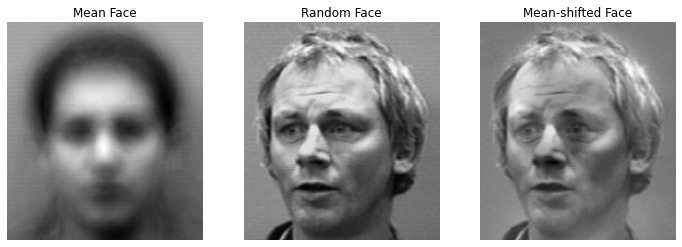

In [68]:
# Initialize the class
A = FacialRec()

# Show the mean face
plt.subplot(1,3,1)
plt.title("Mean Face")
show(A.meanface)

# Show a random face
plt.subplot(1,3,2)
plt.title("Random Face")
show(A.faces[:,0])

# Show the mean-shifted version of the random face
plt.subplot(1,3,3)
plt.title("Mean-shifted Face")
show(A.shiftedfaces[:,0])

# Resize the figure to make it easier to see
plt.gcf().set_size_inches(12,4)

### Problem 3

- In `FacialRec.__init__()`, compute the compact SVD of $\bar{F}$ and store the $U$ as an attribute.
- Use `show()` to display some of the eigenfaces (the columns of $U$).
- Implement `FacialRec.project()` (in a single line).


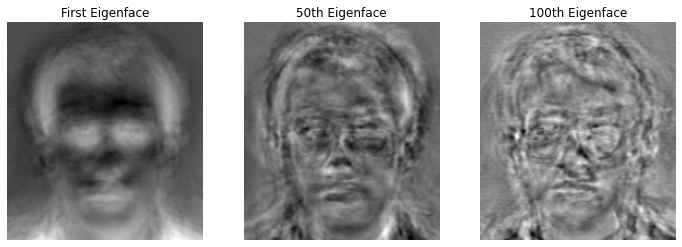

In [69]:
# Show the first eigenface
plt.subplot(1,3,1)
plt.title("First Eigenface")
show(A.U[:,0])

# Show the 50th eigenface
plt.subplot(1,3,2)
plt.title("50th Eigenface")
show(A.U[:,49])

# Show the 100th eigenface
plt.subplot(1,3,3)
plt.title("100th Eigenface")
show(A.U[:,99])

# Resize the figure to make it easier to see
plt.gcf().set_size_inches(12,4)

### Problem 4

- Select one of the shifted images $\bar{\mathbf{f}}_i$.
- For at least 4 values of $s$, use `FacialRec.project()` to compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$.
- Display each of the reconstructions and the original image.

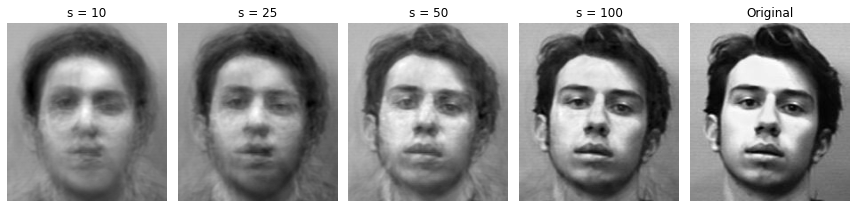

In [70]:
# Select one of the shifted faces and give the levels of detail in s
testface = A.shiftedfaces[:,20]
detail = [10, 25, 50, 100]

# loop through the levels of detail
for s in detail:
    # Project the face onto the eigenfaces of s
    proj = A.project(testface, s)
    recon = A.Us @ proj  + A.meanface

    # Show the reconstructed face
    plt.subplot(1,len(detail)+ 1, detail.index(s) + 1)
    plt.title("s = {}".format(s))
    show(recon)

# Print the original face
plt.subplot(1,len(detail) + 1, len(detail) + 1)
plt.title("Original")
show(testface + A.meanface)

# Resize the figure to make it easier to see
plt.gcf().set_size_inches(12,4)
plt.tight_layout()

### Problem 5 
Implement `FacialRec.find_nearest()`.

### Problem 6

- Implement `FacialRec.match()`.
- Generate some random faces with `sample_faces()`, and use `FacialRec.match()` to find the closest match (let $s=38$).
- For each test, display the sample image and its closest match.

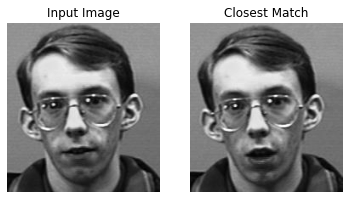

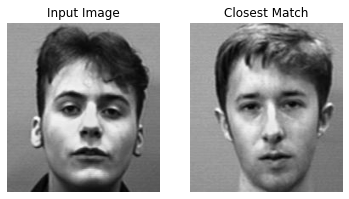

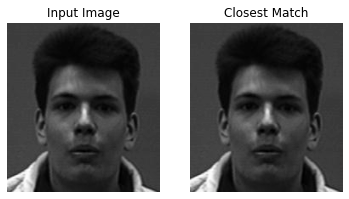

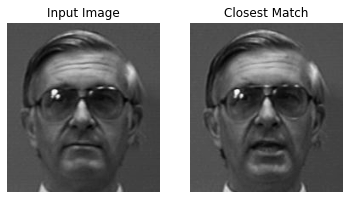

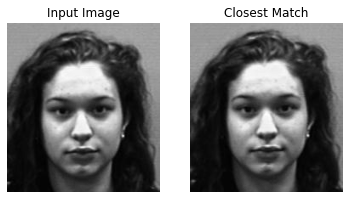

In [71]:
# Get the sample faces
faces = sample_faces(5)

# Loop through each face in the sample and match it to the database and show the results
for face in faces:
    A.match(face)
    plt.show()